<center>
<img src="QWZ.svg" alt="drawing" width="600"/>


In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.linalg as sl
from IPython.display import display
from ipywidgets import*

In [533]:
class QWZ_model_dirty_edge:
    '''
    QWZ model class
    '''
    def __init__(self, L, delta):
        '''
        Initializing the class
        '''
        
        self.L = L 
        self.d = delta
        
        self.tol = 1e-8
        
        #pauli matrices
        self.sigma_0 = np.array([[1,0],[0,1]])
        self.sigma_x = np.array([[0,1],[1,0]])
        self.sigma_y = np.array([[0,-1j],[1j,0]])
        self.sigma_z = np.array([[1,0],[0,-1]])
        
        
        self.U = delta * self.sigma_z
        self.T_x = 0.5 * (self.sigma_z + 1j*self.sigma_x)
        self.T_y = 0.5 * (self.sigma_z + 1j*self.sigma_y)

################ QWZ lead #############################
        
    def create_lead(self):
        '''QWZ lead''' 
        
        self.U = self.d * self.sigma_z
        Hu = np.kron(np.eye(self.L), self.U)
        
        #unit cell
        h0 = np.eye(self.L, k=1)
        H0 = np.matrix(np.kron(h0, self.T_x))
        self.H0 = Hu + H0 + H0.H
        self.dim = np.shape(H0)[0]
        
        #relations between unit cells
        h1 = np.eye(self.L)
        #---------singular matrix...-----------------infinitesimally small diagonal matrix to solve singular H1 matrix problem
        self.H1 = np.matrix(np.kron(h1, self.T_y)) + self.tol*np.eye(self.dim) 
        
    
    def lead_spectrum(self, K):
        '''calculate the spectrum as a function of mumentum'''
        #create lead
        self.create_lead()
        
        l = len(K)
        S = np.zeros((l,self.dim))
        for i in range(l):
            k = K[i]
            S[i,:]=np.linalg.eigvalsh(self.H0 + np.exp(1.0j*k) * self.H1+np.exp(-1.0j*k)*self.H1.H)
            
        return S 
    
    def plot_lead_spectrum(self):
        ''''''
        
        k=np.linspace(-np.pi, np.pi)
        S = self.lead_spectrum(k)
        
        fig, ax = plt.subplots(1,1, figsize = (9,6))


        ax.plot(k,S, '--')

        ax.set_xticks(np.linspace(-np.pi,np.pi, 5))
        ax.set_xticklabels([r'$-\pi$',r'$-\pi/2$',r'$0$',r'$\pi/2$',r'$\pi$'])

        ax.set_yticks(np.linspace(np.min(S), np.max(S), 5))
        ax.set_ylim(1.1*np.min(S),1.1*np.max(S))

        ax.tick_params(labelsize=20, direction='inout', size=10, width=2)

        ax.set_xlabel(r'$k$',fontsize=30)
        ax.set_ylabel(r'$E$',fontsize=30)

        ax.grid()
        
        plt.show()
        
        
    def leads_Green(self,E,**kwargs):
        '''
        Calculate the lead's Green's functions
            based on mezo.py
        '''
             
        O = np.zeros_like(self.H0) #zero block                
        I = np.eye(self.dim) # identity block 
        H1_inv = np.linalg.inv(self.H1)
        
        #eigenvalue problem
        M_1 = np.hstack([-self.H1@(self.H0 - E*I), - H1_inv@self.H1.H]) 
        M_2 = np.hstack([I, O])
        M = np.vstack([M_1,M_2])
        #calculate the eigen values and vectors
        w,v = np.linalg.eigh(M)
        self.w = w
        
        v = np.matrix(v[:self.dim,:]) #ket phi (upper part)
        
        gv=np.zeros_like(w, dtype=complex)
        for i in range(2*self.dim):
            v[:,i] = v[:,i]/np.linalg.norm(v[:,i])  #normalized eigenstate
            gv[i] = 1.0j*((v[:,i].H*(w[i]*self.H1-w[i]**(-1)*self.H1.H)*v[:,i])[0,0]) #group velocity
            
        self.gv = gv
        
        index = np.arange(len(w))
        #-------------------------------------------opened--------------------------------------------------closed
        left = index[np.logical_or(np.logical_and(abs(abs(w)-1)<self.tol, np.real(gv)<0), np.logical_and(abs(abs(w)-1)>self.tol, abs(w)>1))]
        right = index[np.logical_or(np.logical_and(abs(abs(w)-1)<self.tol, np.real(gv)>0), np.logical_and(abs(abs(w)-1)>self.tol, abs(w)<1))]

        
        self.v_left = v[:,left]
        self.w_left  = w[left]
        self.gv_left = gv[left]
        
        self.v_right = v[:,right]
        self.w_right = w[right]
        self.gv_right =gv[right]
        
        if len(self.w_right)!=len(self.w_left):
            print('Problem with partitioning!!', len(self.w_right), len(self.w_left))
            return
        
        #calculate the dual vectors and calculate the preliminaries to the green function
        self.v_right_dual = np.linalg.inv(self.v_right)
        self.v_left_dual  = np.linalg.inv(self.v_left)          
        
        self.T_left    = self.v_left  @ np.matrix(np.diag(1/w[left]))  @ self.v_left_dual
        self.T_right   = self.v_right @ np.matrix(np.diag(w[right]))   @ self.v_right_dual

        #Get Green's functions leads
        self.SG_L = self.T_left@np.linalg.inv(self.H1)
        self.SG_R = self.T_right@np.linalg.inv(self.H1.H)

        
        
################ Bulk sample #############################

    def create_hamiltonian(self, W, alpha=0, V_size=0, V_pos=None):
        '''Create the hamiltonian of a finite rectangle sample and add a scatter (as a random matrix)'''
        
        if W:
            self.W = W # width of the sample
        else:
            self.W = self.L
            
        self.s = self.L * self.W # the size
        
        #size and position of V
        try:
            self.VW = V_size[0]
            self.VL = V_size[1]
        except:
            self.VW = self.VL = V_size
            
        self.Vs = self.VW * self.VL
    
        if V_pos:
            try:
                self.Vx = V_pos[0]
                self.Vy = V_pos[1]
            except:
                self.Vx = self.Vy = pos
        else:
            self.Vx = 0
            self.Vy = np.floor((self.W-self.VW)/2)
        
            
        x_range = np.arange(self.L) 
        y_range = np.arange(self.W)
        y_coordinates, x_coordinates = np.meshgrid(y_range, x_range)
        (self.y_coordinates,self.x_coordinates) = (y_coordinates.flatten(),x_coordinates.flatten()) #coordinates to mark the place of the scattering part
        
        
        ## the hamiltonina of the sample 
        H_u = np.kron(np.eye(self.s), self.U) #onsite
        
        #hoppings
        
        h_x = np.kron(np.eye(self.W), np.eye(self.L, k=-1))
        H_x = np.matrix(np.kron(h_x, self.T_x))
        
        h_y = np.kron(np.eye(self.W, k=-1), np.eye(self.L))
        H_y = np.matrix(np.kron(h_y, self.T_y))
        
        self.H = H_u + H_x + H_x.H + H_y + H_y.H

########################

        HH=sp.linalg.block_diag(*[QWZ.H0 for _ in range(self.W)])
        HH = HH + np.kron(np.eye(self.W,self.L,k=1), QWZ.H1) + np.kron(np.eye(self.W,self.L,k=1), QWZ.H1).H
        self.H = HH
        #add the scatterer
        if self.Vs > 0:
            self.V_x_coord = self.Vx + np.array([0,self.VL-1,self.VL-1,0,0]) #the coordinates of the scatterer
            self.V_y_coord = self.Vy + np.array([0,0,self.VW-1,self.VW-1,0])

            self.temp = matplotlib.path.Path(np.array([self.V_x_coord, self.V_y_coord]).T)
            V = matplotlib.path.Path(np.array([self.V_x_coord, self.V_y_coord]).T)        
            self.V_lattice = (V.contains_points(np.array([self.x_coordinates, self.y_coordinates]).T, radius=0.1)) #lattice sites inside the scttering part

            self.n_scattering_sites = np.sum(self.V_lattice) #number of sites in the scaterer
            self.V_ham = V.contains_points(np.array([np.kron(self.x_coordinates,np.ones(2)), np.kron(self.y_coordinates,np.ones(2))]).T,radius=0.1)
            self.mask = np.kron(self.V_ham.reshape((self.V_ham.size,1)), self.V_ham) #the covered part of the original matrix 

            dim = 2*self.n_scattering_sites
            R0 = np.random.randn(dim,dim)+np.random.rand(dim,dim)*1.0j 
            R0 = alpha * (R0+np.transpose(np.conjugate(R0))).flatten() # random unitary matrix
            self.R = np.zeros_like(self.H)
            self.R[self.mask] = R0 #embedding to a zero matrix
            self.H_S = self.H + self.R
            #self.V = self.H[self.mask].reshape((2*self.n_scattering_sites, 2*self.n_scattering_sites))
        else:    
            self.H_S = self.H
            
        

    def lattice_plot(self):
        '''function to plot the scatterer on lattice'''
        fig, ax = plt.subplots(1,1,figsize=(8,8))

        if self.Vs > 0:
            ax.plot(self.V_x_coord,self.V_y_coord, 'r-')
            ax.fill(self.V_x_coord,self.V_y_coord, color='r', alpha=0.6)
            ax.text(self.Vx-0.5+self.VL/2, self.Vy-0.5+self.VW/2, '$\hat{V}$', ha='center', va='center', fontsize=30)
            ax.plot(self.x_coordinates[np.logical_not(self.V_lattice)], self.y_coordinates[np.logical_not(self.V_lattice)], 'ko')
            ax.plot(self.x_coordinates[self.V_lattice], self.y_coordinates[self.V_lattice], 'o', color='tab:red')
        else:
            ax.plot(self.x_coordinates, self.y_coordinates, 'ko')
            
        ax.set_xticks(np.arange(0,self.L,1))
        ax.set_xticklabels(np.arange(0,self.L,1) + 1)
        ax.set_yticks(np.arange(0,self.W,1))
        ax.set_yticklabels(np.arange(0,self.L,1) + 1)
        ax.tick_params(size=10, direction='inout', width=2, labelsize=15)

        plt.show()
        

    def bulk_spectrum_and_density(self):
        ''''''
        e,v = np.linalg.eigh(self.H_S)
    
        return e,v
    
    def Green(self, E):
        ''' '''
        
        self.E = E + self.tol * 1j
        self.leads_Green(self.E) 
        self.SG_B = np.linalg.inv(self.E * np.eye(2*self.s)-self.H_S) #the Green's function of the scaterer
        
        #decoupled Green's functions
        self.G0 = sp.linalg.block_diag(self.SG_L, self.SG_B, self.SG_R)
        

    def Dyson(self):
        '''Dyson equation'''
        
        # coupling
        self.V = np.vstack([np.hstack([np.zeros_like(self.H1) ,self.H1, np.zeros((self.H1.shape[0], self.G0.shape[1]-2*self.H1.shape[1]))]),
                            np.hstack([self.H1.H,  np.zeros((self.H1.shape[0], self.G0.shape[1]-self.H1.shape[1]))]),
                            np.zeros((self.G0.shape[1]-4*self.H1.shape[1], self.G0.shape[1])),
                            np.hstack([np.zeros((self.H1.shape[0], self.G0.shape[1]-self.H1.shape[1])), self.H1]),
                            np.hstack([np.zeros((self.H1.shape[0], self.G0.shape[1]-2*self.H1.shape[1])),self.H1.T,np.zeros_like(self.H1)])])
        
        self.G = np.linalg.inv(np.linalg.inv(self.G0) - self.V)

        
    def LDOS(self, E, delta=-1, alpha=0, W=None, V_size=(6,3)):
        ''''''
        
        self.U = delta * self.sigma_z
        self.create_lead()
        self.create_hamiltonian(W,alpha, V_size) # add sample with scaterer
        self.Green(E) #lead's Green's functions at E
        self.Dyson() #Dyson's equation
        
        self.D = np.imag(np.diagonal(self.G))
        ldos = []
        
        for i in np.arange(0,len(self.D),2):
            ldos.append(self.D[i]+self.D[i+1])
       
        return np.array(ldos).reshape(self.W+2, self.L)

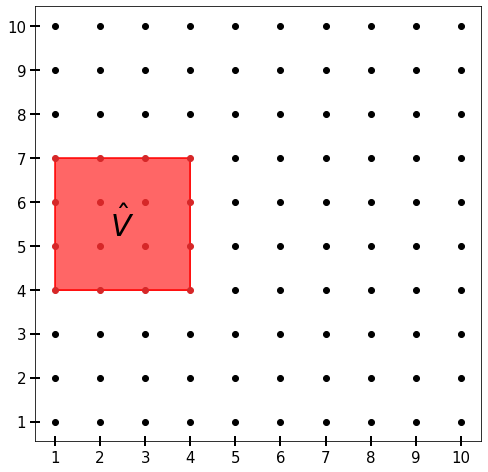

In [513]:
QWZ = QWZ_model_dirty_edge(10,-1)
Ldos = QWZ.LDOS(0,alpha=0.5,V_size=4)
QWZ.lattice_plot()

In [529]:
QWZ = QWZ_model_dirty_edge(10,-1)
ldos = QWZ.LDOS(2,W=10)

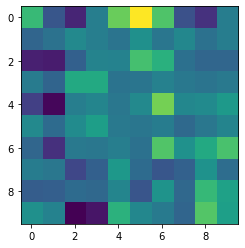

In [532]:
plt.imshow(ldos[1:-1,:])
plt.show()

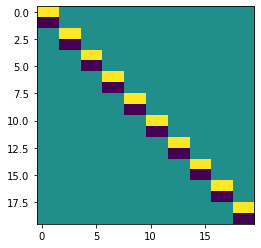

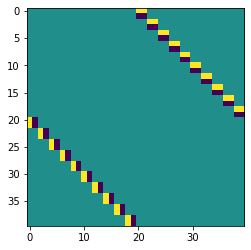

In [515]:
plt.imshow(np.real(QWZ.H1))
plt.show()

plt.imshow(np.real(QWZ.V[0:40,0:40]))
plt.show()

In [524]:
QWZ = QWZ_model_dirty_edge(10,-2)
ldos = QWZ.LDOS(-3.93632823,alpha=0, W=10)
G=np.imag(np.diagonal(QWZ.SG_B))

In [525]:
g=[]
for i in np.arange(0,len(G),2):
    g.append(G[i]+G[i+1])

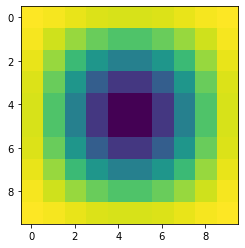

In [526]:
plt.imshow(np.array(g).reshape((int(len(g)/10),10)))

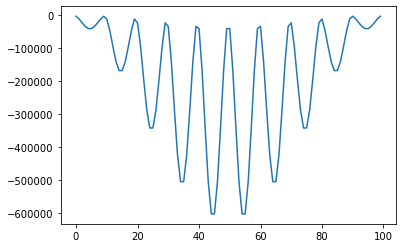

In [527]:
plt.plot(g)

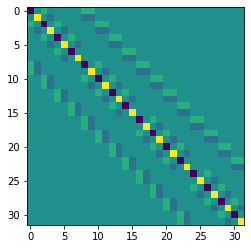

In [519]:
plt.imshow(np.real(QWZ.H_S))